In [103]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision.transforms import transforms

from torch.utils.data import random_split, DataLoader

import matplotlib.pyplot as plt

from tqdm import tqdm
from PIL import Image

%matplotlib inline

In [33]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    else:
        return data.to(device, non_blocking=True)
    
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
            
    def __len__(self):
        return len(self.dl)

In [34]:
device = get_default_device()
print(f'Device: {device}')

Device: cuda


In [35]:
train_batch_size = 64
num_epochs = 35
lr = 5e-3
input_size = 28

# 1. Normally load the dataset and Examine the datea

In [36]:
dataset = MNIST(root = 'data/',
               train=True,
               download=True)
test_dataset = MNIST(root='data/',
                    train=False,
                    download=True)

In [37]:
len(dataset), len(test_dataset)

(60000, 10000)

In [38]:
print(dataset[0])
print(type(dataset[0]))
print(type(dataset[0][0]))

(<PIL.Image.Image image mode=L size=28x28 at 0x234176999D0>, 5)
<class 'tuple'>
<class 'PIL.Image.Image'>


label: 5


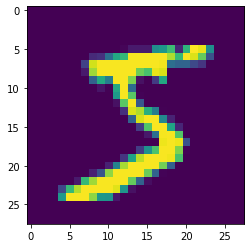

In [39]:
img, label = dataset[0]
plt.imshow(img)
print("label: {}".format(label))

label: 7


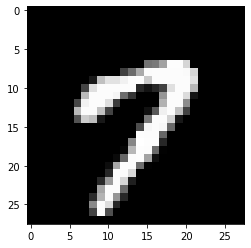

In [40]:
img, label = dataset[15]
plt.imshow(img, cmap='gray')
print(f'label: {label}')

# 2. Load the Dataset again to Type Tensor

In [41]:
ds = MNIST(root = 'data/',
               train=True,
               download=True,
          transform=transforms.ToTensor())
test_ds = MNIST(root='data/',
                    train=False,
                    download=True,
          transform=transforms.ToTensor())
len(ds), len(test_ds)

(60000, 10000)

In [42]:
print(ds[0][0].shape)
print(type(ds[0]))
print(type(ds[0][0]))

torch.Size([1, 28, 28])
<class 'tuple'>
<class 'torch.Tensor'>


label: 5


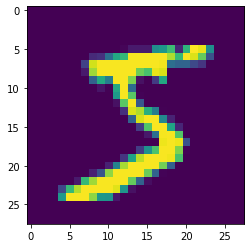

In [43]:
img, label = ds[0]
plt.imshow(img.permute(1,2,0))
print("label: {}".format(label))

label: 7


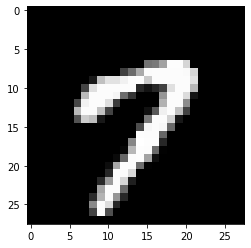

In [44]:
img, label = ds[15]
plt.imshow(img[0,:,:], cmap='gray') 
print("label: {}".format(label))

# 3. Create Data Loading Dataset

In [45]:
# train_dl = DataLoader(ds, train_batch_size, shuffle=True)

train_dl = DeviceDataLoader(DataLoader(ds, train_batch_size, shuffle=True),
                            device)

# 4. Create the Autoencoder Model

In [46]:
class AutoEncoder_orig(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        
        self.input_size = input_size
        
        self.encoder = nn.Sequential(
            nn.Linear(input_size * input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 36),
            nn.ReLU(),
            nn.Linear(36, 18),
            nn.ReLU(),
            nn.Linear(18, 9),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(9, 18),
            nn.ReLU(),
            nn.Linear(18, 36),
            nn.ReLU(),
            nn.Linear(36, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_size * input_size),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
class AutoEncoder(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        
        self.input_size = input_size
        
        self.encoder = nn.Sequential(
            nn.Linear(input_size * input_size, 392),
            nn.ReLU(),
            nn.Linear(392, 196),
            nn.ReLU(),
            nn.Linear(196, 98),
            nn.ReLU(),
            nn.Linear(98, 49),
            nn.ReLU(),
            nn.Linear(49, 24),
            nn.ReLU(),
            nn.Linear(24, 12),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(12, 24),
            nn.ReLU(),
            nn.Linear(24, 49),
            nn.ReLU(),
            nn.Linear(49, 98),
            nn.ReLU(),
            nn.Linear(98, 196),
            nn.ReLU(),
            nn.Linear(196, 392),
            nn.ReLU(),
            nn.Linear(392, input_size * input_size),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# 5. Create the model and the fit function

In [47]:
# model = AutoEncoder(input_size)
model = to_device(AutoEncoder(input_size), device)

def fit(num_epochs, lr, model, train_dl, loss_fn=nn.MSELoss(),
       opt_fn=torch.optim.Adam):
    
    optimizer = opt_fn(model.parameters(), lr=lr, weight_decay=1e-6)
    
    history = list()
    
    for epoch in range(num_epochs):
        
        # for each epoch, do one round of training on all the data in 
        # the training dataset
        loss_list = []
        for data in tqdm(train_dl, total=len(train_dl)):
            images, labels = data
#         for images, labels in train_dl:
            
            images = images.reshape(-1, input_size*input_size)
            outputs = model(images)
            
            loss = loss_fn(outputs, images)
            loss.backward()
            
            loss_list.append(loss.item())
#             print(loss_list)
            
            optimizer.step()
            optimizer.zero_grad()
            
        avg_loss = sum(loss_list) / len(loss_list)
            
        history.append(avg_loss)
        
    return history
            
            
    

In [48]:
%%time
history = fit(num_epochs, lr, model, train_dl)

100%|██████████| 938/938 [00:11<00:00, 78.59it/s]

Wall time: 7min 8s


In [55]:
len(history), history

(35,
 [0.05531583260943387,
  0.04356563534897401,
  0.03950558098227675,
  0.03421142961242115,
  0.031843250663057446,
  0.030602762012927137,
  0.029762821129040676,
  0.028556919968458636,
  0.027641048313362768,
  0.026976846575514593,
  0.02648565766097767,
  0.026011862470381168,
  0.025708842357354506,
  0.025474067020819766,
  0.025286913208012133,
  0.02500308223211689,
  0.024947053873971073,
  0.02483540544036164,
  0.0246611909329224,
  0.024548226087761204,
  0.024224951474079444,
  0.02375120063151505,
  0.023357817331261473,
  0.02323749237485341,
  0.02298916131258011,
  0.02278779521941948,
  0.022675798826618618,
  0.022536795211038484,
  0.02253535320398523,
  0.02234953130756233,
  0.022164332908766866,
  0.02189164992961993,
  0.021591881760703858,
  0.02123754978902749,
  0.0209473469910194])

In [58]:
history[-10:]

[0.02278779521941948,
 0.022675798826618618,
 0.022536795211038484,
 0.02253535320398523,
 0.02234953130756233,
 0.022164332908766866,
 0.02189164992961993,
 0.021591881760703858,
 0.02123754978902749,
 0.0209473469910194]

# 6. Plot the results

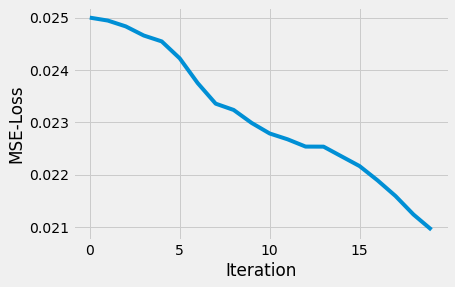

In [59]:
plt.style.use('fivethirtyeight')
plt.xlabel('Iteration')
plt.ylabel('MSE-Loss')
plt.plot(history[-20:])

# 7. Test some samples

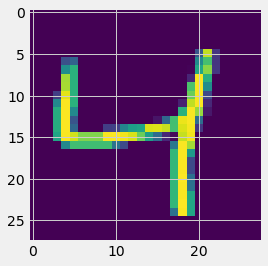

In [82]:
test_idx = 2
test_img = ds[test_idx][0]

plt.imshow(test_img.permute(1,2,0))


In [83]:
# out_img = model(test_img.reshape(-1, input_size*input_size))
# out_img = out_img.reshape(1, input_size, input_size).detach()

# # plt.imshow(out_img.detach().numpy())
# plt.imshow(out_img.permute(1,2,0))

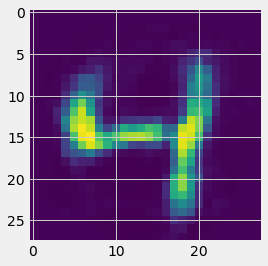

In [84]:
test_img = to_device(test_img, device)
out_img = model(test_img.reshape(-1, input_size*input_size))
out_img = out_img.reshape(1, input_size, input_size).detach().cpu()

# plt.imshow(out_img.detach().numpy())
plt.imshow(out_img.permute(1,2,0))

In [91]:
img_tensor.dtype

torch.uint8

In [104]:
im = Image.open(r"C:\Users\calvi\Downloads\cropped.jpg")
im.show()

In [105]:
# Transfrom from PIL to Tensor
transform = transforms.Compose([
    transforms.PILToTensor()
])
img_tensor = transform(im)
# plt.imshow(img_tensor.permute(1,2,0))

In [106]:
# Resize to fit the model expectation
transform_resize = transforms.Resize((input_size,input_size))
resized_img = transform_resize(img_tensor)
resized_img.shape


torch.Size([3, 28, 28])

In [108]:
# Reduce the channel from 3 to 1 to meet the model expectation
transform_channel = transforms.Grayscale(1)
chan_img = transform_channel(resized_img)
chan_img = chan_img.type(torch.float32)
chan_img.shape

torch.Size([1, 28, 28])

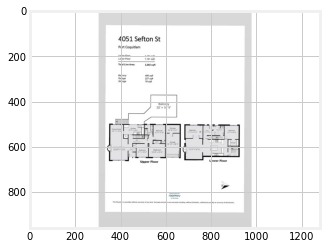

In [109]:
plt.imshow(img_tensor.permute(1,2,0))

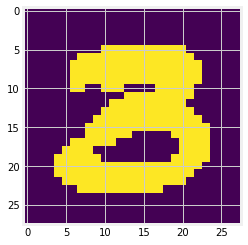

In [110]:
test_img = to_device(chan_img, device)
out_img = model(test_img.reshape(-1, input_size*input_size))
out_img = out_img.reshape(1, input_size, input_size).detach().cpu()

# plt.imshow(out_img.detach().numpy())
plt.imshow(out_img.permute(1,2,0))

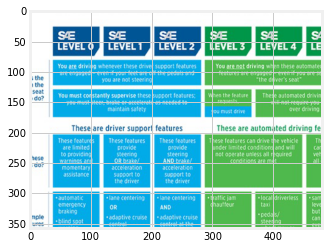

In [116]:
im = Image.open(r"C:\Users\calvi\Documents\Python_Scripts\2023\Playground\simple_autoencoder_mnist\data\sae.jpg")
plt.imshow(im)

In [117]:
# Transfrom from PIL to Tensor
transform = transforms.Compose([
    transforms.PILToTensor()
])
img_tensor = transform(im)
print(img_tensor.shape)

# Resize to fit the model expectation
transform_resize = transforms.Resize((input_size,input_size))
resized_img = transform_resize(img_tensor)
print(resized_img.shape)

# Reduce the channel from 3 to 1 to meet the model expectation
transform_channel = transforms.Grayscale(1)
chan_img = transform_channel(resized_img)
chan_img = chan_img.type(torch.float32)
print(chan_img.shape)

torch.Size([3, 358, 481])
torch.Size([3, 28, 28])
torch.Size([1, 28, 28])


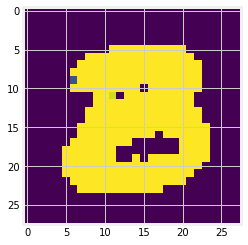

In [119]:
test_img = to_device(chan_img, device)
out_img = model(test_img.reshape(-1, input_size*input_size))
out_img = out_img.reshape(1, input_size, input_size).detach().cpu()

# plt.imshow(out_img.detach().numpy())
plt.imshow(out_img.permute(1,2,0))

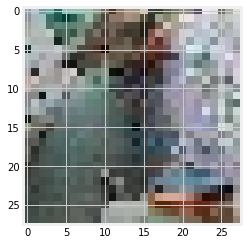

In [122]:
im = Image.open(r"C:\Users\calvi\Documents\Python_Scripts\2023\Playground\simple_autoencoder_mnist\data\sparkles.jpg")
plt.imshow(im)

In [123]:
# Transfrom from PIL to Tensor
transform = transforms.Compose([
    transforms.PILToTensor()
])
img_tensor = transform(im)
print(img_tensor.shape)

# Resize to fit the model expectation
transform_resize = transforms.Resize((input_size,input_size))
resized_img = transform_resize(img_tensor)
print(resized_img.shape)

# Reduce the channel from 3 to 1 to meet the model expectation
transform_channel = transforms.Grayscale(1)
chan_img = transform_channel(resized_img)
chan_img = chan_img.type(torch.float32)
print(chan_img.shape)

torch.Size([3, 28, 28])
torch.Size([3, 28, 28])
torch.Size([1, 28, 28])


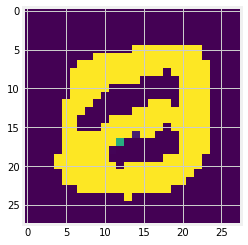

In [124]:
test_img = to_device(chan_img, device)
out_img = model(test_img.reshape(-1, input_size*input_size))
out_img = out_img.reshape(1, input_size, input_size).detach().cpu()

# plt.imshow(out_img.detach().numpy())
plt.imshow(out_img.permute(1,2,0))